In [14]:
import numpy as np
import pandas as pd

In [15]:
df=pd.read_csv("D:\Rohan\ML\Datasets\Air Passengers\AirPassengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [23]:
def create_lag_features(df, lag_steps=1):
    for i in range(1, lag_steps + 1):
         df[f'lag_{i}'] = df['Passengers'].shift(i)
    return df

lagged_data = create_lag_features(df, lag_steps=3)
df.head()

,Month,Passengers,lag_1,lag_2,lag_3
0,1949-01-01,112,NaN,NaN,NaN
1,1949-02-01,118,112.0,NaN,NaN
2,1949-03-01,132,118.0,112.0,NaN
3,1949-04-01,129,132.0,118.0,112.0
4,1949-05-01,121,129.0,132.0,118.0


In [24]:
def create_rolling_mean(df, window_size=3):
    df['rolling_mean'] = df['Passengers'].rolling(window=window_size).mean()
    return df


rolled_data = create_rolling_mean(df, window_size=5)
df.head()

,Month,Passengers,lag_1,lag_2,lag_3,rolling_mean
0,1949-01-01,112,NaN,NaN,NaN,NaN
1,1949-02-01,118,112.0,NaN,NaN,NaN
2,1949-03-01,132,118.0,112.0,NaN,NaN
3,1949-04-01,129,132.0,118.0,112.0,NaN
4,1949-05-01,121,129.0,132.0,118.0,122.4


In [26]:
# Applying Fourier transformation for capturing seasonality

from scipy.fft import fft

def apply_fourier_transform(df):

    values = df['Passengers'].values

    fourier_transform = fft(values)

    df['fourier_transform'] = np.abs(fourier_transform)

    return df

# Applying Fourier transformation to the dataset

fourier_data = apply_fourier_transform(df)
df.head()

,Month,Passengers,lag_1,lag_2,lag_3,rolling_mean,fourier_transform
0,1949-01-01,112,NaN,NaN,NaN,NaN,40363.000000
1,1949-02-01,118,112.0,NaN,NaN,NaN,8947.507129
2,1949-03-01,132,118.0,112.0,NaN,NaN,4098.979094
3,1949-04-01,129,132.0,118.0,112.0,NaN,3267.013269
4,1949-05-01,121,129.0,132.0,118.0,122.4,2327.051980


In [29]:
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

X_train = train_data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'fourier_transform']]
y_train = train_data['Passengers']
X_test = test_data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'fourier_transform']]
y_test = test_data['Passengers']

In [30]:
# Hyperparameter tuning using grid search

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [31]:
print(best_params)

{'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1.0}


In [33]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(**best_params)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 90.3743846907953
MAE: 68.44653530778557


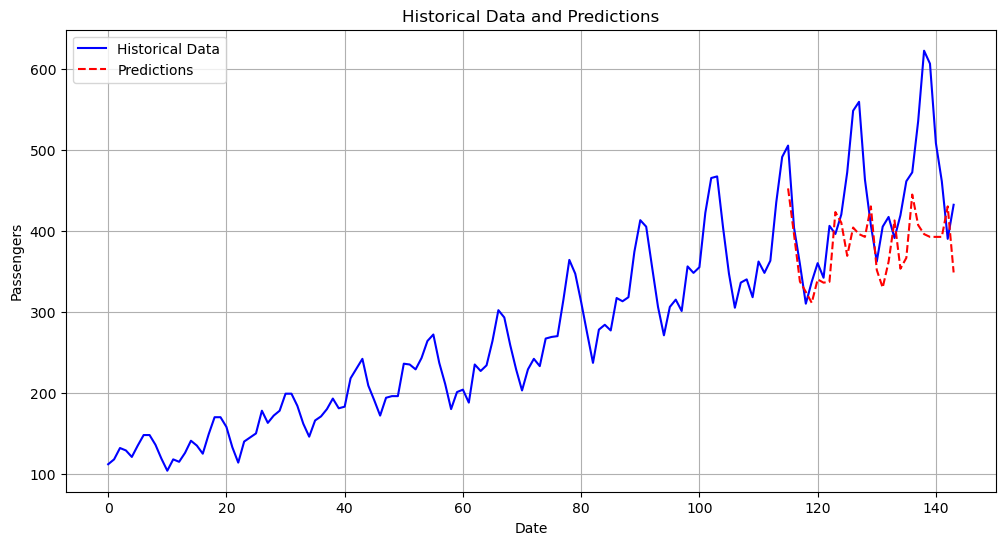

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Historical Data', color='blue')
plt.plot(test_data.index, predictions, label='Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Historical Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()